# Dogs vs. Cats

Creating an algorithm to distinguish dogs from cats using Tensorflow

Link: <a href="https://www.kaggle.com/c/dogs-vs-cats/data">Kaggle challenge</a>

### Libraries

In [58]:
from os import listdir, makedirs
from os.path import isfile, join, exists
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Global variables

In [59]:
width = 56
height = 56
depth = 1

### Helper functions

This sections is necessary to define small blocks of code that will show many times in the algorithm to process infos.

In [60]:
# This function will show at digit.
def show_image(arr, label):
    plt.imshow(arr)
    plt.title("Animal: {}".format(label))
    return plt

# Getting informations picture and setting in an array.
def get_data_image(folder):
    path = folder
    files = [f for f in listdir(path) if isfile(join(path, f))]

    data = []
    for item in files:
        result = 1 if 'dog' in item else 0
        data.append([np.asarray(PIL.Image.open(folder + item)),result])
    return data

### Process images functions

In [61]:
# Resizing dimensions of image.
def resize_image(img, width, height, directory_destiny):
    if not exists(directory_destiny):
        makedirs(directory_destiny)
    
    # open an image file   
    # adjust width and height to your needs
    # use one of these filter options to resize the image
    # convert 'L' is monochrome
    new_image = PIL.Image.open(img).resize((width, height), PIL.Image.NEAREST).convert('L')
    #new_image = new_image.convert('1')
    new_image.save(directory_destiny + img.split("/")[1])

# This method will select all images in a directory and resize it in another directory.
def process_resize_images(directory, directory_destiny, width, height):
    files = [f for f in listdir(directory) if isfile(join(directory, f))]
    for item in files:
        resize_image(directory + item, width, height, directory_destiny)

### Model functions

In [78]:
# This function contains the train method and predict of tensorflow
def cnn_model(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, width, height, depth])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 14 * 14 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Loading the training and test data set

In code bellow, there are two examples of data, one dog and one cat. It will convert images in numpy array

In [63]:
img1 = np.asarray(PIL.Image.open('train/cat.0.jpg'))
print (img1.shape)

img2 = np.asarray(PIL.Image.open('train/dog.1.jpg'))
print (img2.shape)

(374, 500, 3)
(499, 327, 3)


<module 'matplotlib.pyplot' from 'c:\\users\\msgru\\anaconda2\\envs\\tensorflow-py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

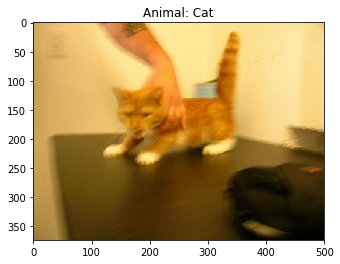

In [64]:
# show cat image
show_image(img1, 'Cat')

<module 'matplotlib.pyplot' from 'c:\\users\\msgru\\anaconda2\\envs\\tensorflow-py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

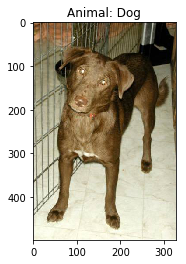

In [65]:
# show cat image
show_image(img2, 'Dog')

Let's resize the image to decrease the dimensions of the image and thereby slow down processing.

In [66]:
process_resize_images('train/', 'rezise-train/', width, height)
process_resize_images('test1/', 'rezise-test1/', width, height)

Now, the code will select the files in the directory and convert them to a numpy array

In [67]:
data = get_data_image('rezise-train/')
print (len(data))

25000


Showing informations about image like array and label

In [68]:
print("Format image: " + str(data[0][0].shape) + " Label: " + str(data[0][1]))
print("Format image: " + str(data[24999][0].shape) + " Label: " + str(data[24999][1]))

Format image: (56, 56) Label: 0
Format image: (56, 56) Label: 1


Showing dog's image after resize process.

<module 'matplotlib.pyplot' from 'c:\\users\\msgru\\anaconda2\\envs\\tensorflow-py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

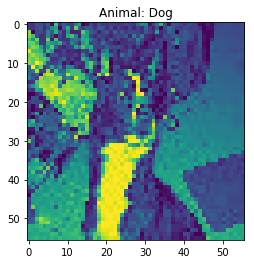

In [69]:
show_image(data[23000][0], "Dog" if data[23000][1] == 1 else "Cat")

### Training model with dogs and cats images

In [70]:
np_data = np.array(data)
label = np_data[:,1].astype(int)
images = np_data[:,0]

print (len(label))
print (len(np_data[:,0]))

25000
25000


In [71]:
# Adjusting array image
arr_images = []
for i in range(len(images)):
    line = []
    for j in range(len(images[i])):
        for k in range(len(images[i][j])):
            line.append(images[i][j][k])
    arr_images.append(line)

In [72]:
arr_images = np.array(arr_images).astype(float)
print (len(arr_images[0]))
print (label)

3136
[0 0 0 ... 1 1 1]


In [73]:
print ((arr_images[0]))

[168. 177. 185. ...   1.   0.   0.]


In [79]:
###################################
####### Create the Estimator ######
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model, model_dir="C:\\Users\\msgru\\Documents\\Git\\Outros\\Dogs-Cats\\convnet_model")

##########################################
###### Set up logging for predictions
###### Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

##############################
####### Train the model ######
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": arr_images},
    y=label,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=500,
    hooks=[logging_hook])
###############################

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_tf_random_seed': None, '_save_checkpoints_steps': None, '_task_id': 0, '_train_distribute': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001AA00192DD8>, '_is_chief': True, '_session_config': None, '_keep_checkpoint_max': 5, '_master': '', '_model_dir': 'C:\\Users\\msgru\\Documents\\Git\\Outros\\Dogs-Cats\\convnet_model', '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_service': None}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\

INFO:tensorflow:loss = 46.96719741821289, step = 1
INFO:tensorflow:probabilities = [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 

INFO:tensorflow:loss = 0.009808243252336979, step = 101 (214.211 sec)
INFO:tensorflow:probabilities = [[0.99999705 0.00000178 0.00000094 0.         0.         0.00000019
  0.         0.00000002 0.         0.        ]
 [0.99998628 0.00000343 0.00000201 0.00000007 0.0000005  0.00000075
  0.00000102 0.00000428 0.00000162 0.00000002]
 [0.99999786 0.00000213 0.         0.         0.         0.
  0.         0.00000001 0.         0.        ]
 [0.99997212 0.00002784 0.         0.         0.         0.
  0.         0.00000003 0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999956 0.00000044 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999869 0.00000131 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.99999764 0.0000006  0.00000001 0.         0.00000001 0.00000009
  0.00000004 0.0000016  0.         0.00000001]
 [0.9999974  0.000

INFO:tensorflow:global_step/sec: 0.463406
INFO:tensorflow:probabilities = [[0.17483178 0.80627217 0.00347146 0.00220309 0.00189019 0.00376676
  0.00200346 0.00103308 0.00430059 0.00022742]
 [0.15549588 0.82513646 0.00632234 0.00160167 0.00202877 0.00449157
  0.00110417 0.00088284 0.00272681 0.00020949]
 [0.08398382 0.91589213 0.00002633 0.00001069 0.00000328 0.00002502
  0.00000436 0.00002226 0.00003199 0.00000013]
 [0.33337506 0.57464468 0.01803846 0.01400658 0.01690073 0.01710682
  0.00585886 0.00893129 0.00882592 0.00231159]
 [0.10536559 0.89233514 0.00126794 0.00000739 0.00012301 0.0006502
  0.00005051 0.00006449 0.00013521 0.00000052]
 [0.05973369 0.94026457 0.00000009 0.00000013 0.00000001 0.00000052
  0.00000004 0.00000091 0.00000004 0.        ]
 [0.03968627 0.96023212 0.00002849 0.00000391 0.00000403 0.0000275
  0.00000201 0.00000663 0.00000902 0.00000003]
 [0.14575515 0.85228438 0.00031037 0.00013225 0.00049692 0.00018591
  0.00009521 0.00007714 0.00065178 0.0000109 ]
 [0.1868

INFO:tensorflow:loss = 0.2865290343761444, step = 201 (215.789 sec)
INFO:tensorflow:probabilities = [[0.00009207 0.99990792 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00119471 0.99878993 0.00000139 0.00000105 0.00000017 0.00000923
  0.00000175 0.00000095 0.00000082 0.00000001]
 [0.00001604 0.99998382 0.00000007 0.         0.00000001 0.00000005
  0.         0.00000001 0.00000001 0.        ]
 [0.00000086 0.99999914 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02125658 0.97873988 0.00000017 0.00000077 0.00000015 0.0000021
  0.00000002 0.00000008 0.00000025 0.        ]
 [0.00521923 0.99478068 0.00000007 0.         0.         0.00000002
  0.         0.         0.         0.        ]
 [0.001257   0.99865599 0.0000217  0.00000172 0.00002417 0.00001529
  0.00000155 0.00000296 0.00001958 0.00000004]
 [0.0497002  0.95029935 0.00000022 0.00000004 0.00000001 0.00000003
  0.00000004 0.00000009 0.00000004 0.       

INFO:tensorflow:Saving checkpoints for 297 into C:\Users\msgru\Documents\Git\Outros\Dogs-Cats\convnet_model\model.ckpt.
INFO:tensorflow:global_step/sec: 0.560612
INFO:tensorflow:probabilities = [[0.00000001 0.99999999 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00010768 0.9998923  0.         0.         0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00014625 0.99985375 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00257584 0.99741772 0.0000029  0.00000043 0.00000032 0.0000024
  0.00000002 0.00000002 0.00000034 0.        ]
 [0.00448772 0.99506436 0.00032378 0.00001129 0.00001069 0.00008123
  0.00000711 0.00000231 0.00001141 0.00000011]
 [0.00000624 0.99999376 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00028087 0.99971913 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.00001181 0.99998814 0.00000002

INFO:tensorflow:loss = 0.0011663835030049086, step = 301 (178.375 sec)
INFO:tensorflow:probabilities = [[0.99854099 0.00145705 0.00000014 0.00000002 0.00000019 0.00000006
  0.00000083 0.00000061 0.00000009 0.        ]
 [0.94540075 0.05438729 0.00001708 0.00007257 0.0000114  0.00003726
  0.00000321 0.00001438 0.00005545 0.0000006 ]
 [0.98905213 0.01092709 0.00000224 0.00000104 0.00000391 0.0000044
  0.00000241 0.00000607 0.00000065 0.00000006]
 [0.97781583 0.02179285 0.00009337 0.00001455 0.00002051 0.00004046
  0.00008748 0.00009979 0.00003145 0.00000371]
 [0.99969234 0.00027821 0.00000244 0.00000026 0.00000109 0.0000028
  0.00000454 0.00001617 0.00000152 0.00000064]
 [0.96214966 0.0374922  0.00004671 0.00002075 0.00000531 0.00009261
  0.00006927 0.00003978 0.0000814  0.0000023 ]
 [0.88499299 0.11495076 0.00001904 0.0000123  0.00000171 0.00000171
  0.00000174 0.00001228 0.00000518 0.00000227]
 [0.99274693 0.00724219 0.00000042 0.00000325 0.0000001  0.00000675
  0.         0.00000011 0.

INFO:tensorflow:global_step/sec: 0.548134
INFO:tensorflow:probabilities = [[0.99709007 0.00281372 0.00000952 0.00000225 0.0000073  0.00001335
  0.0000082  0.00002369 0.00002814 0.00000375]
 [0.99979621 0.0002009  0.00000035 0.00000003 0.0000008  0.00000072
  0.00000026 0.00000023 0.00000039 0.00000012]
 [0.99971073 0.00028746 0.00000009 0.00000001 0.0000001  0.00000021
  0.00000097 0.00000027 0.00000015 0.00000001]
 [0.9995078  0.00034116 0.00000501 0.00000063 0.00000932 0.00006031
  0.00000031 0.00007115 0.00000377 0.00000053]
 [0.99860792 0.00128068 0.00001453 0.00001395 0.00000928 0.00003608
  0.00002182 0.00000658 0.00000886 0.00000029]
 [0.99932544 0.00066689 0.00000654 0.00000004 0.00000019 0.00000027
  0.00000009 0.00000008 0.00000046 0.00000001]
 [0.99979578 0.0002019  0.00000061 0.00000006 0.00000036 0.00000028
  0.00000013 0.00000064 0.00000022 0.00000002]
 [0.99999044 0.00000951 0.         0.         0.         0.
  0.00000001 0.00000002 0.         0.00000001]
 [0.9999996  0

INFO:tensorflow:loss = 0.002185943303629756, step = 401 (182.440 sec)
INFO:tensorflow:probabilities = [[0.08457544 0.91526317 0.00003574 0.00003414 0.00001718 0.00002464
  0.00000387 0.00000708 0.00003869 0.00000004]
 [0.00605297 0.99394185 0.00000062 0.00000052 0.00000025 0.00000361
  0.00000008 0.00000003 0.00000008 0.        ]
 [0.04020391 0.95974615 0.00001015 0.00000437 0.00000397 0.00001904
  0.00000052 0.00000063 0.00001125 0.00000001]
 [0.02801786 0.9719641  0.00000208 0.00000101 0.00000264 0.00001009
  0.00000059 0.00000039 0.00000122 0.00000002]
 [0.01554729 0.98444693 0.00000126 0.00000023 0.00000157 0.00000204
  0.00000007 0.00000006 0.00000056 0.        ]
 [0.25035868 0.74428261 0.00130414 0.00029621 0.00119505 0.00123071
  0.00024508 0.00021427 0.00085123 0.00002201]
 [0.06542326 0.93252573 0.00017493 0.00020496 0.00014202 0.00082615
  0.00016625 0.00027148 0.00025048 0.00001473]
 [0.02536427 0.97439171 0.00006748 0.00003344 0.00000402 0.00012252
  0.00000112 0.0000094  0

INFO:tensorflow:Saving checkpoints for 500 into C:\Users\msgru\Documents\Git\Outros\Dogs-Cats\convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.006056756246834993.


In [80]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": arr_images[:,:].astype(float)},
  num_epochs=1,
  shuffle=False)
test_results = mnist_classifier.predict(input_fn=predict_input_fn)

In [81]:
results = [res for res in test_results]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\msgru\Documents\Git\Outros\Dogs-Cats\convnet_model\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [83]:
print (results[24999])
print (results[0])

{'classes': 1, 'probabilities': array([1.09766030e-04, 9.99890233e-01, 5.68725453e-10, 5.84161208e-11,
       6.57797920e-11, 4.47112221e-10, 3.68986821e-12, 2.98089839e-12,
       2.32765046e-10, 4.60338831e-15])}
{'classes': 1, 'probabilities': array([1.70332734e-03, 9.98283558e-01, 5.16291052e-06, 3.33977081e-07,
       1.65483768e-06, 4.07820830e-06, 2.34353301e-07, 1.17896522e-07,
       1.52942298e-06, 2.90337280e-09])}
